In [29]:
import os
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as tv
import torch.optim as optim
from PIL import Image
import logging
import matplotlib.pyplot as plt
import copy
import pandas as pd
from statistics import mean
from torchvision.utils import save_image
%matplotlib inline

In [30]:
mylogs = logging.getLogger()
mylogs.setLevel(logging.INFO)
# Logging to file
file = logging.FileHandler("training.log", mode='w')
file.setLevel(logging.INFO)
fileformat = logging.Formatter("%(asctime)s:%(levelname)s:%(message)s",datefmt="%H:%M:%S")
file.setFormatter(fileformat)
mylogs.addHandler(file)
# Logging to console
stream = logging.StreamHandler()
stream.setLevel(logging.INFO)
mylogs.addHandler(stream)
torch.cuda.empty_cache()

In [31]:
train_dir = r"E:/cancer_dataset/hi_res_train/"
model_name = 'Hi_Res_DCGAN'
project_name = "Resolution augmentation"
image_size = 160
down_sampling = 4
lambda_gp = 10

# Creating img list

In [32]:
mylogs.info("Generative Adversarial Network")
mylogs.info(f"Project : {project_name}")

Generative Adversarial Network
Generative Adversarial Network
Project : Resolution augmentation
Project : Resolution augmentation


In [33]:
def create_img_list(folder):
    img_list = []
    img_list = list()
    for (dirpath, dirnames, filenames) in os.walk(folder):
            img_list += [os.path.join(dirpath, file) for file in filenames]
    return img_list

In [34]:
train_img_list = create_img_list(train_dir)

In [35]:
get_initial_transform = tv.Compose([
        tv.CenterCrop((image_size, image_size)),
        tv.RandomHorizontalFlip(p=0.5),
        tv.RandomVerticalFlip(p=0.5),
    ])
lowres_transform = tv.Compose([
       tv.ToTensor(),
       tv.Resize(int(image_size/down_sampling), tv.InterpolationMode.BICUBIC),
    ])
highres_transform = tv.Compose([
        tv.ToTensor(),
    ])
transforms = (get_initial_transform,lowres_transform,highres_transform )

# Image Loading functions

In [36]:
class loadDataset(Dataset):
    def __init__(self, image_size,down_sampling, img_list, transforms):
        super().__init__()
        self.imgs = img_list
        self.image_size = image_size
        self.down_sampling = int(image_size / down_sampling)
        self.transforms = transforms
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        image_path = self.imgs[idx]
       
      ### Reading, converting and normalizing image, creating low res version
        img = Image.open(image_path)
        img = img.resize((image_size, image_size))
        img = self.transforms[0](img)
        low_res =  self.transforms[1](img)
        high_res = self.transforms[2](img)
        return high_res, low_res
        
    def __len__(self):
        return len(self.imgs)

In [37]:
train_dataset = loadDataset(image_size, down_sampling, train_img_list, transforms)

In [38]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 0,
    batch_size = 2,
    pin_memory = True,
    shuffle = True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


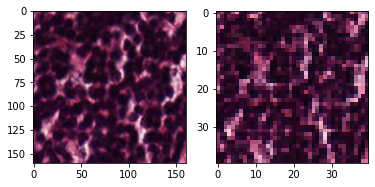

In [39]:
def dataset_preview(train_data_loader):
    for high_res_img, low_res_img in train_data_loader:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        high_res_img = high_res_img[1,:,:,:]
        low_res_img = low_res_img[1,:,:,:]
        ax1.imshow(high_res_img.permute(1,2,0))
        ax2.imshow(low_res_img.permute(1,2,0))
        break
        
dataset_preview(train_data_loader)

# Functions for training

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
mylogs.info(f"Device is: {str(device)}")

Device is: cuda


In [13]:
import GAN
from GAN import gradient_penalty, initialize_weights, test
# Create the generator
netG = GAN.Generator(in_channels=3, num_channels = 64)
netG = netG.to(device)

# Print the model
print(netG)
initialize_weights(netG)

Generator(
  (initial): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (residuals): Sequential(
    (0): RRDB(
      (rrdb): Sequential(
        (0): DenseResidualBlock(
          (blocks): ModuleList(
            (0): ConvBlock(
              (cnn): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (1): ConvBlock(
              (cnn): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (2): ConvBlock(
              (cnn): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (3): ConvBlock(
              (cnn): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): LeakyReLU(negative_slope=0.2, inplace=True)
            )


In [14]:
# Create the Discriminator
netD = GAN.Discriminator()
netD = netD.to(device)
# Print the model
print(netD)

Discriminator(
  (blocks): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): ConvBlock(
      (cnn): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): ConvBlock(
      (cnn): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): ConvBlock(
      (cnn): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): ConvBlock(
      (cnn): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): ConvBlock(
      (cnn): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): LeakyReLU(negative_slope=0.2, inp

In [15]:
#https://github.com/AquibPy/Enhanced-Super-Resolution-GAN/blob/main/loss.py
import torch.nn as nn
from torchvision.models import vgg19

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:35].eval().to(device)
        self.loss = nn.MSELoss()

        for params in self.vgg.parameters():
            params.requires_grad = False
    
    def forward(self,input,target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features,vgg_target_features)


In [16]:
criterion = VGGLoss
optimizerG = optim.Adam(netG.parameters(), lr=1e-4, betas=(0.0, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=1e-4, betas=(0.0, 0.999))
l1 = nn.L1Loss()
vgg_loss = VGGLoss()

In [17]:
mylogs.info("Model: " + model_name )

Model: Hi_Res_DCGAN


In [18]:
def train_one_epoch(data_loader,model_G, model_D, optimizer_G, optimizer_D):
    ### Local Parameters
    epoch_G_loss = []
    epoch_D_loss = []
    train_iter = 0
    start_time = time.time()
    ###Iterating over data loader
    for hi_res_image,low_res_image in data_loader:
        hi_res_image = hi_res_image.float()
        low_res_image = low_res_image.float()
        hi_res_image = hi_res_image.to(device)
        low_res_image = low_res_image.to(device)
        high_res_fake = model_G(low_res_image)
        disc_real = model_D(hi_res_image)
        disc_fake = model_D(high_res_fake.detach())
        grad_penalty = gradient_penalty(model_D, hi_res_image, high_res_fake, device)
        loss_disc = (-(torch.mean(disc_real) - torch.mean(disc_fake))+ lambda_gp * grad_penalty)
        optimizer_D.zero_grad()
        loss_disc.backward()
        optimizer_D.step()
        disc_fake = model_D(high_res_fake)
        l1_loss = 1e-2 * l1(high_res_fake, hi_res_image)
        adversarial_loss = 5e-3 * -torch.mean(model_D(high_res_fake))
        loss_vgg = vgg_loss(high_res_fake,hi_res_image)
        loss_gen = l1_loss+ adversarial_loss + loss_vgg
        
        # generator is trained every 5th batch of descriminator's training
        if train_iter % 5 == 0:
            optimizer_G.zero_grad()
            loss_gen.backward()
            optimizer_G.step()
            
        train_iter += 1
        end_time = time.time()
        total_time = int(end_time - start_time)/60
        # Save Losses for plotting later
        epoch_G_loss.append(float(loss_gen))
        epoch_D_loss.append(float(loss_disc))
        
    return mean(epoch_G_loss), mean(epoch_D_loss), total_time, high_res_fake

In [19]:
def report_in_progress(epoch, G_loss, D_loss, _time):
       #Print epoch details
        mylogs.info(f'Training: Epoch {epoch}: | G_Loss: {G_loss:.5f} | D_loss: {D_loss:.3f} | Time: {(round(_time, 4))}')

In [20]:
# Saving the best model
def save_model(model_g,project_name, model_name):
    torch.save({'model_name': model_name,
                'model_state_dict': model_g.state_dict(),
                }, f'{project_name}_{model_name}_generator.pt')

In [21]:
def train_model(data_loader, model_G, model_D, optimizer_G, optimizer_D, max_n_epochs):
    path = r'E:/colon_dataset/training/' 
    start_time = time.time()
    # initializing  training stats
    train_logs =  {"G_loss" : [], "D_loss" : [], "time" : []}
    mylogs.info("Training started")
    current_epoch = 0
    img_list = []
    for epoch in range(1, max_n_epochs + 1):
        G_loss, D_loss, train_time,high_res_fake = train_one_epoch(data_loader, model_G, model_D,
                                                 optimizer_G, optimizer_D)
        #Print train Epoch Details      
        report_in_progress( epoch, G_loss, D_loss, train_time)
        #Adding stats for the epoch
        train_logs["G_loss"].append(G_loss)
        train_logs["D_loss"].append(D_loss)
        train_logs["time"].append(train_time)
          # saving progress images and a model
        save_image(high_res_fake, f"epoch{str(epoch)}.tiff")
        save_model(model_G, project_name, model_name)

    end_time = time.time()
    total_time = end_time - start_time
    mylogs.info(f"Total time : {int(total_time/60)}")
    training_stats = {}
    training_stats['train logs'] = train_logs
    generator_state_dict = model_G.state_dict()
    
    return (model_G, model_D),generator_state_dict, training_stats, img_list

In [22]:
# Training de novo
n_of_epochs = 100
model, generator_state_dict, training_stats, img_list = train_model(train_data_loader, netG, netD, optimizerG, optimizerD, n_of_epochs)

Training started
Training: Epoch 1: | G_Loss: 4.70261 | D_loss: -44.576 | Time: 11.5167
Training: Epoch 2: | G_Loss: 1.30613 | D_loss: -20.984 | Time: 10.3
Training: Epoch 3: | G_Loss: 1.27558 | D_loss: -15.005 | Time: 10.1
Training: Epoch 4: | G_Loss: 0.50588 | D_loss: -13.218 | Time: 10.15
Training: Epoch 5: | G_Loss: 0.76285 | D_loss: -12.960 | Time: 10.1667
Training: Epoch 6: | G_Loss: 0.37191 | D_loss: -11.182 | Time: 10.2333
Training: Epoch 7: | G_Loss: 1.30343 | D_loss: -11.555 | Time: 10.2667
Training: Epoch 8: | G_Loss: 0.90050 | D_loss: -11.187 | Time: 10.2167
Training: Epoch 9: | G_Loss: 1.90640 | D_loss: 76.163 | Time: 10.2333
Training: Epoch 10: | G_Loss: 3.13547 | D_loss: -10.696 | Time: 10.2167
Training: Epoch 11: | G_Loss: 2.50749 | D_loss: -10.680 | Time: 10.15
Training: Epoch 12: | G_Loss: 1.91452 | D_loss: -10.217 | Time: 10.1667
Training: Epoch 13: | G_Loss: 1.23269 | D_loss: -10.281 | Time: 10.1833
Training: Epoch 14: | G_Loss: 1.40307 | D_loss: -9.749 | Time: 10.1

# Saving and evaluating resulting model

In [23]:
def train_vis(training_stats,epochs):
    epochs = epochs + 1
    ### Plotting Results
    train_logs = training_stats['train logs']

#Loss
    plt.title("Loss",color='black')
    plt.plot(np.arange(1, epochs), train_logs['G_loss'], color = 'blue', label='Generator loss')
    plt.plot(np.arange(1, epochs), train_logs['D_loss'], color = 'orange', label='Discriminator loss')
    plt.xticks(ticks=range(1, epochs, 50), color='black')
    plt.yticks(color='black')
    plt.xlabel("Epochs", color = 'black')
    plt.ylabel("Loss", color = 'black')
    plt.show()


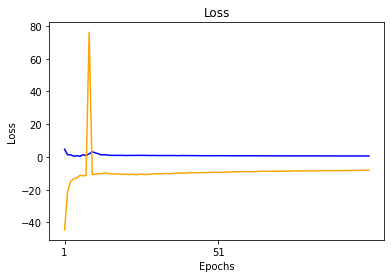

In [24]:
train_vis(training_stats,n_of_epochs)

In [25]:
get_image_transform = tv.Compose([
        tv.CenterCrop((image_size, image_size))
        ])

In [26]:
def training_preview(image_path, generator, name):
        img = Image.open(image_path)
        img_downsized= img.resize((int(image_size/down_sampling), int(image_size/down_sampling)))
        img_bicubic = img.resize((int(image_size/down_sampling), int(image_size/down_sampling)))
        img_bicubic = img_bicubic.resize((image_size, image_size),Image.BICUBIC)
        img = img.resize((image_size, image_size))
      
        img = get_image_transform(img)
        
        low_res_img =  lowres_transform(img)
        high_res_img = highres_transform(img)
        
        low_res_img = np.expand_dims(low_res_img, 0)
        low_res_img = torch.from_numpy(low_res_img)
        
        generator = generator.to(device)
        
        low_res_img = low_res_img.to(device)
        high_res_gen = generator(low_res_img)
        high_res_gen = high_res_gen.to('cpu')
        
        high_res_gen = high_res_gen.squeeze()
        high_res_gen =  high_res_gen.permute(1,2,0)
        high_res_img = high_res_img.permute(1,2,0)
        
        high_res_gen = high_res_gen.detach().numpy()

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(15,15))
       
        ax1.set_title("Original image")
        ax2.set_title("Downsized image")
        ax3.set_title("Bicubic upscale image")
        ax4.set_title("GAN upscale image")

        ax1.imshow(high_res_img)
        ax2.imshow(img_downsized)
        ax3.imshow(img_bicubic)
        ax4.imshow(high_res_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


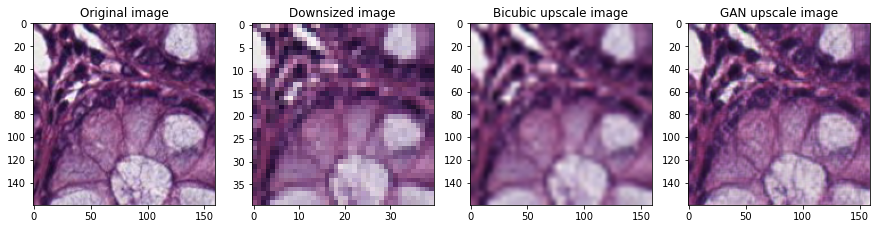

In [28]:
image_path = r'E:\cancer_dataset\hi_res_train\1041C_CRC-Prim-HE-05.tif_Row_901_Col_1351.jpg'
training_preview(image_path, model[0], model_name )